#  Generate transmission for Auxtel #

- adaptation of notebooks from https://github.com/lsst/rubin_sim_notebooks/tree/main/photometry


This notebook provides an example of calculating the expected AB magnitude in each filter for a user-provided spectral energy distribution (SED) with Rubin Observatory.

Many example SEDs can be found in the `sims_sed_library` (downloadable from NCSA as a [gzipped tar file](https://lsst.ncsa.illinois.edu/sim-data/sed_library/seds_170124.tar.gz)). This file has additional documentation in [confluence](https://confluence.lsstcorp.org/display/SIM/SED+%28Spectral+Energy+Density%29+models+in+the+Catalogs+Simulation+Framework), but includes Kurucz model spectra for main sequence stars, MLT spectra, white dwarf spectra, a range of asteroid spectral types, and various galaxy spectral templates.

This example will use a Kurucz model appropriate for our Sun (`kurucz_sun`) which has been copied into the photometry directory of the [rubin_sim_notebooks](https://github.com/lsst/rubin_sim_notebooks) repository.

The expected format of this file (or any other spectra you want to use) is two columns, the first containing wavelength in nanometers and the second containing either F$_\lambda$ (in ergs/cm$^2$/s/nm) or F$_\nu$ (in Janksy). Our example `kurucz_sun` contains wavelength(nm) / F$_\lambda$(ergs/cm$^2$/s/nm).


In [20]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.interpolate import interp1d

In [2]:
# Import the primary photometry classes from rubin_sim.photUtils
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data.data_sets import  get_data_dir

## Read the throughput curves ##

The throughput curves are currently downloaded as part of the `rs_download_data` script, and stored in `$RUBIN_SIM_DATA_DIR`. The default value for `$RUBIN_SIM_DATA_DIR` is `$HOME/rubin_sim_data`. 

In [3]:
fdir = get_data_dir()
print(fdir)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubin_sim_data


In [6]:
# Find the throughputs directory 
#fdir = os.getenv('RUBIN_SIM_DATA_DIR')
fdir = get_data_dir()
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')


fdir = os.path.join(fdir, 'throughputs', 'auxtel')
ldir = "./"

In [7]:
telescope_throughput = "multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt"

In [8]:
tel_auxtel =  Bandpass()
tel_auxtel.read_throughput(os.path.join(fdir, telescope_throughput ))

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


In [9]:
# Read the throughput curves
filterlist = ['u', 'g', 'r', 'i','z']

sdss_p = {}
for f in filterlist:
    sdss_p[f] = Bandpass()
    sdss_p[f].read_throughput(os.path.join(ldir, f'SDSS_{f}_prime.txt'))

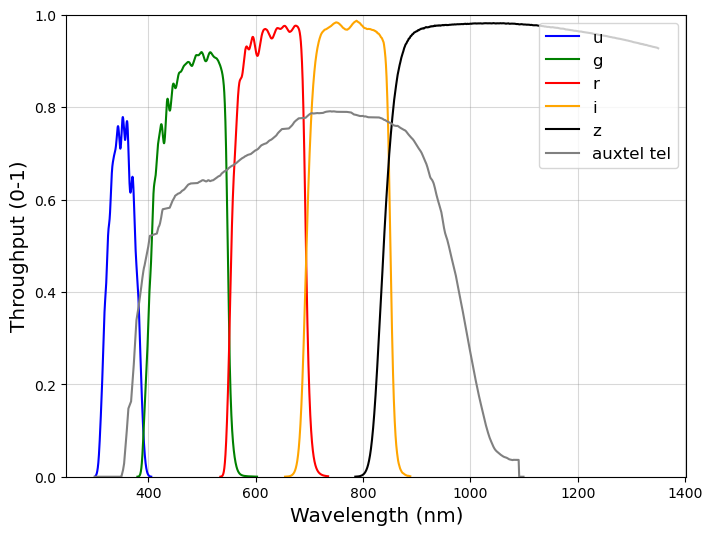

In [10]:
# Plot the curves .. see what we have. 
filtercolors = {'u':'b', 'g':'g', 'r':'r', 'i':'orange', 'z':'k', 'y':'grey'}

plt.figure(figsize=(8,6))
for f in filterlist:
    plt.plot(sdss_p[f].wavelen, sdss_p[f].sb, color=filtercolors[f], label=f)
    
plt.plot(tel_auxtel.wavelen, tel_auxtel.sb, color="grey", label="auxtel tel")

plt.xlabel("Wavelength (nm)", fontsize='x-large')
plt.ylabel("Throughput (0-1)", fontsize='x-large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, color='gray')
plt.legend(loc='upper right', fancybox=True, fontsize='large')

In [11]:
tr_u = np.interp(sdss_p["u"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)
tr_g = np.interp(sdss_p["g"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)
tr_r = np.interp(sdss_p["r"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)
tr_i = np.interp(sdss_p["i"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)
tr_z = np.interp(sdss_p["z"].wavelen, tel_auxtel.wavelen, tel_auxtel.sb)

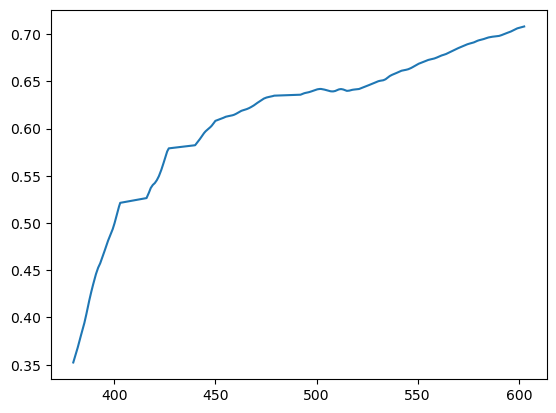

In [18]:
plt.plot(sdss_p["g"].wavelen,tr_g)

In [ ]:
interp1d(x, y

In [21]:
auxtel = {}
auxtel["u"] = Bandpass(wavelen=sdss_p["u"].wavelen,sb=tr_u * sdss_p["u"].sb)
auxtel["g"] = Bandpass(wavelen=sdss_p["g"].wavelen,sb=tr_g * sdss_p["g"].sb)
auxtel["r"] = Bandpass(wavelen=sdss_p["r"].wavelen,sb=tr_r * sdss_p["r"].sb)  
auxtel["i"] = Bandpass(wavelen=sdss_p["i"].wavelen,sb=tr_i * sdss_p["i"].sb)  
auxtel["z"] = Bandpass(wavelen=sdss_p["z"].wavelen,sb=tr_z * sdss_p["z"].sb)  

In [16]:
Bandpass?

Init signature: Bandpass(wavelen=None, sb=None, sampling_warning=0.2)
Docstring:     
Hold and use telescope throughput curves.

Parameters
----------
wavelen : `np.ndarray`, (N,)
    Wavelength array in nm.
sb : `np.ndarray`, (N,)
    Throughput array (fraction, 0-1).
    If wavelength sampling lower than this,
    throw a warning because it might provide accurate magnitudes
    due to how magnitudes are calculated in Sed (nm).
File:           ~/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py
Type:           type
Subclasses:     

Text(0.5, 1.0, 'Auxtel Photometry')

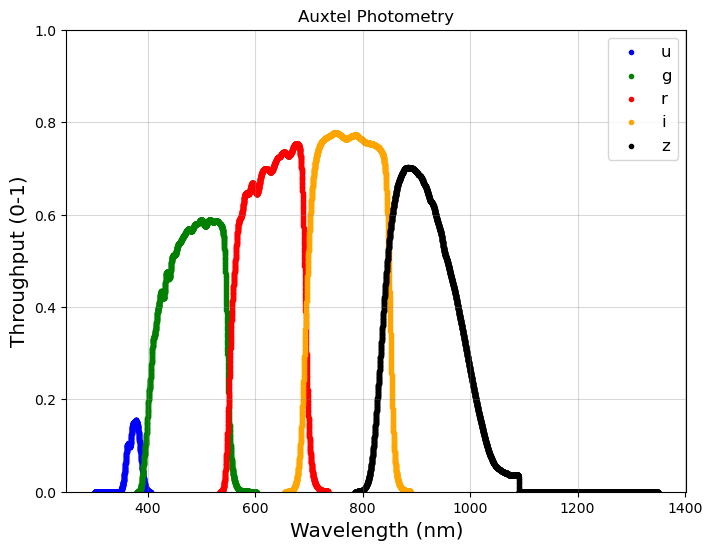

In [24]:
plt.figure(figsize=(8,6))
for f in filterlist:
    plt.scatter(auxtel[f].wavelen, auxtel[f].sb, color=filtercolors[f],marker='.' ,label=f)
    
plt.xlabel("Wavelength (nm)", fontsize='x-large')
plt.ylabel("Throughput (0-1)", fontsize='x-large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, color='gray')
plt.legend(loc='upper right', fancybox=True, fontsize='large')
plt.title("Auxtel Photometry")

In [27]:
auxtel["u"].write_throughput("auxtel_sdss_u.dat")

In [28]:
for f in filterlist:
    filename = f"auxtel_sdss_{f}.dat"
    fullfilename = os.path.join(fdir,filename)
    auxtel[f].write_throughput(fullfilename)